In [2]:
from IPython.core.display import display, HTML
display(HTML("""<style>
.container { width:99% !important; }
div.text_cell_render { /* Customize text cells */
    font-size:1.5em;
    line-height:1.4em;
    padding-left:3em;
    padding-right:3em;
}
</style>"""))

In [3]:
import pandas as pd
import soundfile as sf
from scipy.signal import spectrogram
import numpy as np
from scipy.stats import zscore
from scipy.linalg import svd, toeplitz
from statsmodels.tsa.stattools import acf

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
## Loading dataframes
lag = 512

base = pd.read_pickle('./pkl_datasets/mamiraua_dataset_ACF_' + str(lag) + '.gzip')
cotas = pd.read_csv('./boundary_files/Cotas_HxC_bins_' + str(int(lag)) + '.csv')
noise = pd.read_csv('./coloredNoises/coloredNoises_' + str(int(lag)) + '.csv')

In [8]:
nfft = 1024
path = './mamiraua_samples/segment_'

s1 = '1481150534' # low entropy-low complexity
s2 = '1481169633' # medium entropy-high complexity
s3 = '1481150827' # high entropy-low complexity

# Power spectral density
x1, fs1 = sf.read(path + s1 + '.flac')
x1 = zscore(x1)
f1, t1, Pxx_s1 = spectrogram(x1/np.max(np.abs(x1)), fs1, nfft = nfft, nperseg = nfft, noverlap = nfft/2, window = 'hann', scaling = 'density')

x2, fs2 = sf.read(path + s2 + '.flac')
x2 = zscore(x2)
f2, t2, Pxx_s2 = spectrogram(x2/np.max(np.abs(x2)), fs2, nfft = nfft, nperseg = nfft, noverlap = nfft/2, window = 'hann', scaling = 'density')

x3, fs3 = sf.read(path + s3 + '.flac')
x3 = zscore(x3)
f3, t3, Pxx_s3 = spectrogram(x3/np.max(np.abs(x3)), fs3, nfft = nfft, nperseg = nfft, noverlap = nfft/2, window = 'hann', scaling = 'density')

## Singular spectrums of s1, s2 and s3

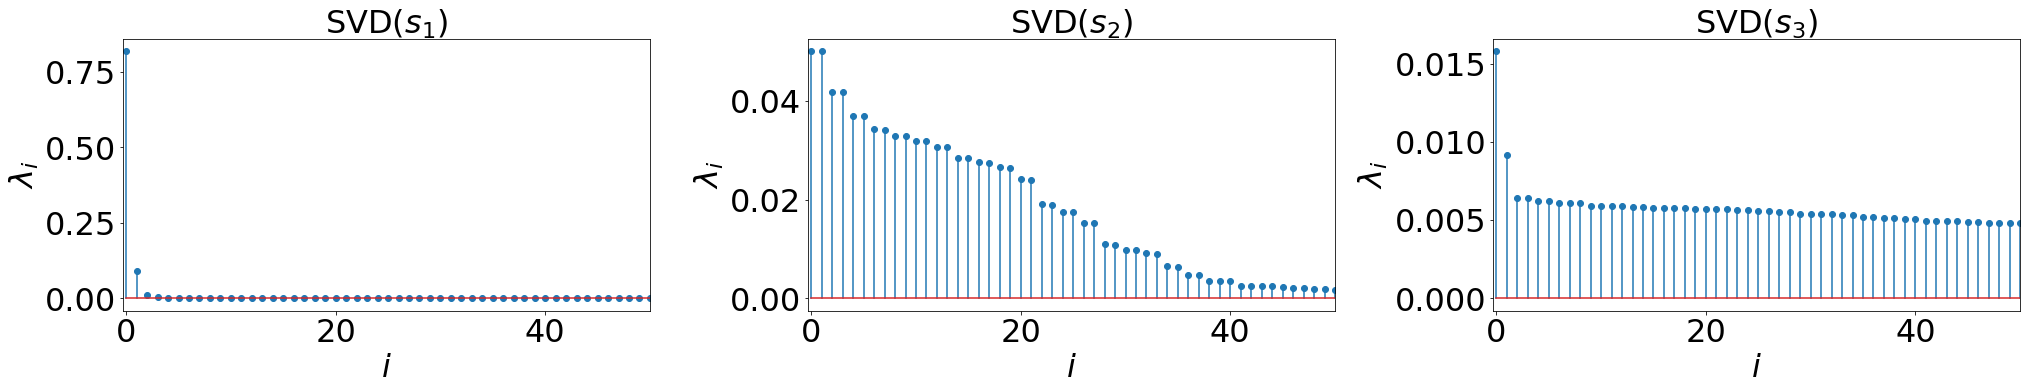

In [9]:
fig = plt.figure(figsize=(34,5))
plt.rc('font', size=32)
plt.rc('axes', titlesize=32)
plt.subplots_adjust(wspace = 0.3)
X = [x1, x2, x3]

for i, x in enumerate(X):
    rxx = acf(x, nlags=lag, unbiased=True, fft=True)
    Sxx = toeplitz(rxx)
    U, s, Vt = svd(Sxx)
    s = s/np.sum(s)
    
    plt.subplot(1,3,i+1)
    
    plt.stem(s[:60])
    plt.xlim([-0.3, 50])
    plt.xlabel('$i$')
    plt.ylabel('$\lambda_i$')
    plt.title('SVD(' + '$s_'+str(i+1)+'$'+')')

fig.savefig('./figures/Fig5.eps', format="eps", bbox_inches='tight')

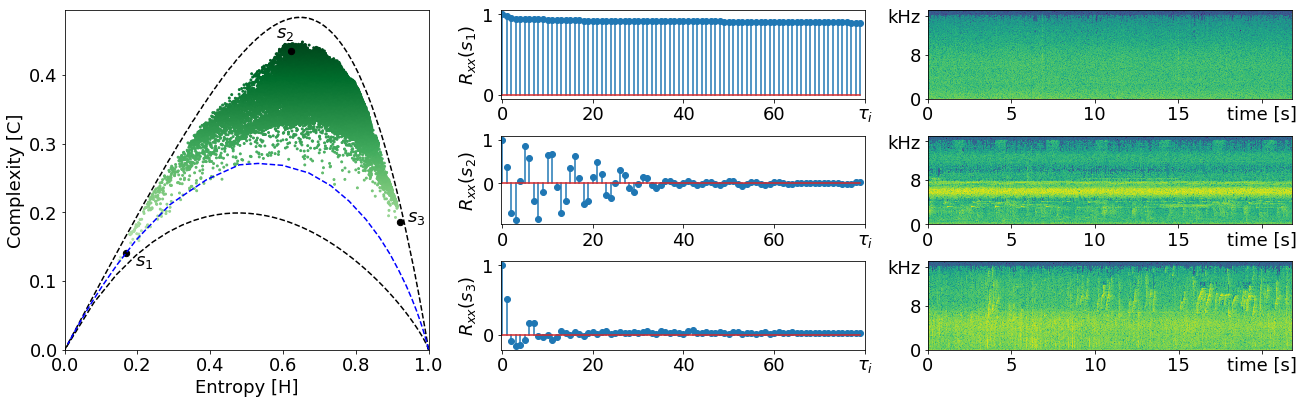

In [10]:
fig = plt.figure(figsize=(18,5.5),constrained_layout=True)
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
gs = fig.add_gridspec(3, 3, wspace=0.5)

ax1 = fig.add_subplot(gs[:,0])
ax1.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax1.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
plt.xlim([0, 1])
plt.ylim([0, np.max(cotas['Complexity'])+0.01])
plt.ylabel('Complexity [C]')
plt.xlabel('Entropy [H]')

ax1.scatter(base['H'], base['C'], marker='.', s=15, c=base['C'], 
            norm=plt.Normalize(vmax=np.max(base['C']), vmin=np.min(base['C'])-0.1),
            cmap = 'Greens') # seismic # viridis # plasma # jet # PuBu # YlOrRd # Blues

ax1.scatter(base[base['segment'] == s1].H.values[0], base[base['segment'] == s1].C.values[0], marker='o', s=40, c='k')
plt.text(base[base['segment'] == s1].H.values[0]+0.025, base[base['segment'] == s1].C.values[0]-0.018, '$s_1$')

ax1.scatter(base[base['segment'] == s2].H.values[0], base[base['segment'] == s2].C.values[0], marker='o', s=40, c='k')
plt.text(base[base['segment'] == s2].H.values[0]-0.04, base[base['segment'] == s2].C.values[0]+0.02, '$s_2$')

ax1.scatter(base[base['segment'] == s3].H.values[0], base[base['segment'] == s3].C.values[0], marker='o', s=40, c='k')
plt.text(base[base['segment'] == s3].H.values[0]+0.02, base[base['segment'] == s3].C.values[0]-0.0, '$s_3$')

ax2 = fig.add_subplot(gs[0, 1])
ax2.stem(base[base['segment'] == s1].ACF_512.values[0][:80])
plt.xticks([0,20,40,60,80],['0','20','40','60',r'$\tau_i$'])
plt.ylabel(r'$R_{xx}(s_1)$')
plt.xlim([-0.3, 80])

ax3 = fig.add_subplot(gs[1, 1])
ax3.stem(base[base['segment'] == s2].ACF_512.values[0][:80])
plt.xticks([0,20,40,60,80],['0','20','40','60',r'$\tau_i$'])
plt.ylabel(r'$R_{xx}(s_2)$')
plt.xlim([-0.3, 80])

ax4 = fig.add_subplot(gs[2, 1])
ax4.stem(base[base['segment'] == s3].ACF_512.values[0][:80])
plt.xticks([0,20,40,60,80],['0','20','40','60',r'$\tau_i$'])
plt.ylabel(r'$R_{xx}(s_3)$')
plt.xlim([-0.3, 80])

ax5 = fig.add_subplot(gs[0, 2])                     
ax5.pcolormesh(t1, f1, np.log(Pxx_s1))
plt.yticks([0,8000, 15000],['0','8', 'kHz'])
plt.xticks([0,5,10,15,20],['0','5','10','15','time [s]'])

ax6 = fig.add_subplot(gs[1, 2])
ax6.pcolormesh(t2, f2, np.log(Pxx_s2))
plt.yticks([0,8000, 15000],['0','8', 'kHz'])
plt.xticks([0,5,10,15,20],['0','5','10','15','time [s]'])

ax7 = fig.add_subplot(gs[2, 2])
ax7.pcolormesh(t3, f3, np.log(Pxx_s3))
plt.yticks([0,8000, 15000],['0','8', 'kHz'])
plt.xticks([0,5,10,15,20],['0','5','10','15','time [s]'])
fig.savefig('./figures/Fig4.png', format="png", bbox_inches='tight')

plt.show()